# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import libraries
from pyspark.sql import SparkSession, Window
import pyspark.sql.functions as F
from pyspark.sql.types import IntegerType
#from pyspark import SparkFiles
#from pyspark.sql.functions import avg, col, concat, count, desc, \
#asc, explode, lit, min, max, split, stddev, udf, isnan, when, rank, \
#log, sqrt, cbrt, exp, sum

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, \
LogisticRegressionModel, RandomForestClassifier, \
RandomForestClassificationModel, GBTClassifier, \
GBTClassificationModel
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics

from pyspark.ml.feature import CountVectorizer, IDF, Normalizer, \
PCA, RegexTokenizer, Tokenizer, StandardScaler, StopWordsRemover, \
StringIndexer, VectorAssembler, MaxAbsScaler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.clustering import KMeans
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

from time import time
import re
import numpy as np
import scipy
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
import seaborn as sns
import random
%matplotlib inline
random.seed(42)

Here's the related [class video](https://youtu.be/ZMSzkDG1BSQ) to create a Spark session. If we use getOrCreate(), if the session alreafy exists, we update it, if it does not exist, a new one will be created. 

In [2]:
# create a Spark session by instantiating a spark object
def create_spark_session():
    spark = SparkSession\
    .builder \
    .master("local") \
    .appName("sparkify") \
    .config("config option", "config value") \
    .getOrCreate()
    print('Spark parameters:')
    [print(parameter) for parameter in spark.sparkContext.getConf().getAll()]

    return spark

In [3]:
# Get session details
spark = create_spark_session()
spark

Spark parameters:
('spark.master', 'local')
('spark.driver.port', '43751')
('spark.app.name', 'sparkify')
('spark.rdd.compress', 'True')
('spark.serializer.objectStreamReset', '100')
('config option', 'config value')
('spark.executor.id', 'driver')
('spark.submit.deployMode', 'client')
('spark.driver.host', '79614a7977c6')
('spark.ui.showConsoleProgress', 'true')
('spark.app.id', 'local-1631216679436')


# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

### Load Dataset

In [4]:
def load_dataset(spark, path = 'mini_sparkify_event_data.json'):
    print(f'Readinng File: {path}')
    df = spark.read.json(path)
    print(f'Columns in dataset: {df.columns}')
    print(f'Datatypes in dataset: {df.persist()}')
    print(f'First DataFrame record: {df.head()}')

    return df

In [5]:
df = load_dataset(spark)

Readinng File: mini_sparkify_event_data.json
Columns in dataset: ['artist', 'auth', 'firstName', 'gender', 'itemInSession', 'lastName', 'length', 'level', 'location', 'method', 'page', 'registration', 'sessionId', 'song', 'status', 'ts', 'userAgent', 'userId']
Datatypes in dataset: DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string]
First DataFrame record: Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0

In [7]:
# pyspark DataFrame
type(df)

pyspark.sql.dataframe.DataFrame

In [8]:
# number of DataFrame rows
df.count()

286500

In [9]:
# number of DataFrame columns
df.columns

['artist',
 'auth',
 'firstName',
 'gender',
 'itemInSession',
 'lastName',
 'length',
 'level',
 'location',
 'method',
 'page',
 'registration',
 'sessionId',
 'song',
 'status',
 'ts',
 'userAgent',
 'userId']

In [10]:
# check datatypes
df.persist()

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string]

In [11]:
# print Schema
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [12]:
# show the first 3 rows of the dataframe
df.show(n=3)

+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+-----------------+------+-------------+--------------------+------+
|          artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|             song|status|           ts|           userAgent|userId|
+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+-----------------+------+-------------+--------------------+------+
|  Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|NextSong|1538173362000|       29|        Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
|Five Iron Frenzy|Logged In|    Micah|     M|           79|    Long|236.09424| free|Boston-Cambridge-...|   PUT|NextSong|1538331630000|        8|   

In [13]:
# use the take() method to see the first two reccords 
df.take(2)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30'),
 Row(artist='Five Iron Frenzy', auth='Logged In', firstName='Micah', gender='M', itemInSession=79, lastName='Long', length=236.09424, level='free', location='Boston-Cambridge-Newton, MA-NH', method='PUT', page='NextSong', registration=1538331630000, sessionId=8, song='Canada', status=200, ts=1538352180000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"', userId='9')]

In [14]:
# show the first five records of `userID` column
df.select("userId").show(3)

+------+
|userId|
+------+
|    30|
|     9|
|    30|
+------+
only showing top 3 rows



### Getting to know the dataset 

Following up [this video](https://youtu.be/pDOlgj0FBdU).

#### Apply `describe()` function on the entire DataFrame to visualize

- count
- mean
- standard deviation
- min
- max

values of each column

We also have to add show() to get all information needed.

In [15]:
df.describe().show()

+-------+------------------+----------+---------+------+------------------+--------+-----------------+------+-----------------+------+-------+--------------------+-----------------+--------------------+------------------+--------------------+--------------------+-----------------+
|summary|            artist|      auth|firstName|gender|     itemInSession|lastName|           length| level|         location|method|   page|        registration|        sessionId|                song|            status|                  ts|           userAgent|           userId|
+-------+------------------+----------+---------+------+------------------+--------+-----------------+------+-----------------+------+-------+--------------------+-----------------+--------------------+------------------+--------------------+--------------------+-----------------+
|  count|            228108|    286500|   278154|278154|            286500|  278154|           228108|286500|           278154|286500| 286500|            

This is a bit messy. For a better visual approoach we need to get just some columns to show. Let's show `artist` **column** or better `artist` **field**.

In [16]:
df.describe("artist").show()

+-------+------------------+
|summary|            artist|
+-------+------------------+
|  count|            228108|
|   mean| 551.0852017937219|
| stddev|1217.7693079161374|
|    min|               !!!|
|    max| ÃÂlafur Arnalds|
+-------+------------------+



Check out a numeric field:

In [17]:
df.describe("sessionId").show()

+-------+-----------------+
|summary|        sessionId|
+-------+-----------------+
|  count|           286500|
|   mean|1041.526554973822|
| stddev|726.7762634630741|
|    min|                1|
|    max|             2474|
+-------+-----------------+



#### Use `dropDuplicates()` 
we see each kind just once and with sort(), we sort them alphabetically.

In [18]:
# check page requests
df.select("page").dropDuplicates().sort("page").show(3)

+---------------+
|           page|
+---------------+
|          About|
|     Add Friend|
|Add to Playlist|
+---------------+
only showing top 3 rows



#### Get specific events 
Get events associated to a particular `userID` by firtering specific events. Get to know how a typical **user event log** might look like.

In [19]:
df.select(["userId", "firstname", "page", "song"]).where(df.userId == "1046").collect()
# userId ised in the video is not available anymore

[]

In [19]:
df.select(['userID','firstName','page','song']).where(df.firstName == "Kenneth").collect() 
# Kenneth is not available anymore

[]

In [20]:
# try a different user
df.select(['userID','firstName','page','song']).where(df.userId == "30").collect()

[Row(userID='30', firstName='Colin', page='NextSong', song='Rockpools'),
 Row(userID='30', firstName='Colin', page='NextSong', song='Time For Miracles'),
 Row(userID='30', firstName='Colin', page='NextSong', song='Harder Better Faster Stronger'),
 Row(userID='30', firstName='Colin', page='NextSong', song='Passengers (Old Album Version)'),
 Row(userID='30', firstName='Colin', page='Add to Playlist', song=None),
 Row(userID='30', firstName='Colin', page='NextSong', song='Fuck Kitty'),
 Row(userID='30', firstName='Colin', page='NextSong', song='Jade'),
 Row(userID='30', firstName='Colin', page='NextSong', song='So-Called Friends'),
 Row(userID='30', firstName='Colin', page='NextSong', song='Represent'),
 Row(userID='30', firstName='Colin', page='NextSong', song='Here I Am'),
 Row(userID='30', firstName='Colin', page='NextSong', song='Rebirthing (Album Version)'),
 Row(userID='30', firstName='Colin', page='NextSong', song='Dog Days Are Over (Radio Edit)'),
 Row(userID='30', firstName='Coli

More on Lazy Evaluation [here](https://data-flair.training/blogs/apache-spark-lazy-evaluation/). You need to use show() or collect() to have spark doing something with data.

### Clean Dataset

##### Check NaNs

Null values, spark DataFrame count using `isNull()` Function. Every column name is passed to `isNull()` function which returns the count of nulls.

In [21]:
df.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId| song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
| 58392|   0|     8346|  8346|            0|    8346| 58392|    0|    8346|     0|   0|        8346|        0|58392|     0|  0|     8346|     0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+



Null values of dataframe count in pyspark using `isNull()` and `isnan()` Functions.

In [22]:
df.select([F.count(F.when(F.isnan(c) | F.col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId| song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
| 58392|   0|     8346|  8346|            0|    8346| 58392|    0|    8346|     0|   0|        8346|        0|58392|     0|  0|     8346|     0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+



In [9]:
nan_dict = {}
def create_nan_dict(df):
    '''
    Description: Gets a spark dataframe and returns a python dictionary with  sum of null values
    Input: Spark DataFrame
    Output: Ordered dicronary ranging from the highest number of nulls to the lowest
    
    '''
    
    # create a dictionary keeping column names and nans
    for col in df.columns:
        nan_dict[col] = df.where(df[col].isNull()|F.isnan(df[col])).select(col).count()
        
        sorted_dict = dict(sorted(nan_dict.items(), key=lambda item: item[1]))
        # plot Null values
    sns.barplot([*sorted_dict.keys()],[*sorted_dict.values()])
    plt.xticks(rotation = 90);
    
    return sorted_dict

Execution time: 0.18145756324132284 minutes


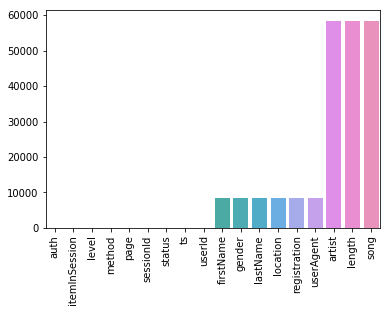

In [24]:
import time
start = time.time()
nan_dict = create_nan_dict(df)
stop = time.time()
print(f'Execution time: {(stop - start)/60} minutes')

We observe that 
- firstName
- gender
- lastName
- registration
- userAgent
have the very same number of null values.

Same goes for 
- artist
- length
- song

Check if "userId", "gender", "lastName", "location", "registration", "userAgent", "firstName" correspond to the same records

In [25]:
# check firstName nans
firstName_cols = len(df.select("firstName").where(df.firstName.isNull()|F.isnan(df.firstName)).collect())

# check rest of columns
rest_of_cols = len(df.select(["userId", "gender", "lastName", "location", "registration", "userAgent"])\
    .where(df.firstName.isNull()|F.isnan(df.firstName))\
    .collect())

firstName_cols == rest_of_cols

True

It looks like they correspond to the same reccords. 

In [26]:
# check persentage of nulls
rest_of_cols/df.count()

0.029130890052356022

They corrispond to 3% of the entire dataset so we can feel free to drop those.

In [27]:
# keep nulls in a separate frame for future use if needed
null_frame = df.filter(df.firstName.isNull()|F.isnan(df.firstName))

# check authentication info in these records
null_frame.groupBy("auth").count().sort("count").show()

# check page info in these records
null_frame.groupBy("page").count().sort("count").show()

+----------+-----+
|      auth|count|
+----------+-----+
|     Guest|   97|
|Logged Out| 8249|
+----------+-----+

+-------------------+-----+
|               page|count|
+-------------------+-----+
|Submit Registration|    5|
|              Error|    6|
|           Register|   18|
|               Help|  272|
|              About|  429|
|              Login| 3241|
|               Home| 4375|
+-------------------+-----+



It looks like they are either "Guests" or "Logged Out" due to authentication issues and none of them has been tryong to downgrade their subscription so nein added value here. We can drop these reccords as they are not meaningfull for the analysis we are performing. 

In [28]:
# drop null values and create log_events to work on from now on
df.dropna(how = "any", subset = ["firstName"]).show(3)

+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+-----------------+------+-------------+--------------------+------+
|          artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|             song|status|           ts|           userAgent|userId|
+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+-----------------+------+-------------+--------------------+------+
|  Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|NextSong|1538173362000|       29|        Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
|Five Iron Frenzy|Logged In|    Micah|     M|           79|    Long|236.09424| free|Boston-Cambridge-...|   PUT|NextSong|1538331630000|        8|   

Further explore nulls in the rest of the data we are elaborating

In [6]:
def clean_dataset(df):
    log_events = df.dropna(how = "any", subset = ["firstName"])
    log_events = log_events.withColumn('song', F.when(log_events.song.isNull(), F.lit("no_song")).otherwise(df.song))
    log_events = log_events.withColumn('artist', F.when(log_events.artist.isNull(), F.lit("no_artist")).otherwise(df.artist))
    log_events = log_events.withColumn('length', F.when(log_events.length.isNull(), F.lit(0)).otherwise(df.length))

    return log_events

In [7]:
log_events = clean_dataset(df)

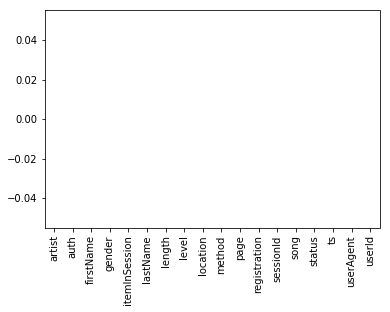

In [10]:
# check nulls on log_events
null_log_dict = create_nan_dict(log_events)

It looks like we are done with NANs. Let's explore further our data.

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

In [32]:
# check downgraded selection given "Cancellation Confirmation" and "Downgrade"
log_events.filter((F.col("page") == 'Cancellation Confirmation')| (F.col("page") == 'Downgrade')).count()

2107

In [11]:
# create downgrade selection using 
def down_selection(page):
    if page == 'Cancellation Confirmation' or page == 'Downgrade':
        return 1
    return 0

In [12]:
def create_churn_col(log_events):
    flag_downgrade_event = F.udf(down_selection, IntegerType())

    log_events = log_events.withColumn('churn',flag_downgrade_event(df['page']))

    return log_events

In [13]:
log_events = create_churn_col(log_events)

In [36]:
log_events.groupBy("churn") \
    .count() \
    .withColumnRenamed('count', 'cnt_per_group') \
    .withColumn('perc_of_count_total', (F.col('cnt_per_group') / log_events.count()) * 100 ) \
    .show()

+-----+-------------+-------------------+
|churn|cnt_per_group|perc_of_count_total|
+-----+-------------+-------------------+
|    1|         2107| 0.7574940500586006|
|    0|       276047|  99.24250594994139|
+-----+-------------+-------------------+



In [37]:
# create a churn user defined function to be used later on in visualizations
churn_func = F.udf(lambda x: 'Churn' if x == 1 else 'Not Churn')

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

#### 1. "userId" feature

In [38]:
# check eventual "userId" typos
log_events.select("userId").dropDuplicates().sort("userId", ascending = False).show(5)
log_events.select("userId").dropDuplicates().sort("userId").show(5)

+------+
|userId|
+------+
|    99|
|    98|
|    97|
|    96|
|    95|
+------+
only showing top 5 rows

+------+
|userId|
+------+
|    10|
|   100|
|100001|
|100002|
|100003|
+------+
only showing top 5 rows



In [39]:
# describe data although you get info only for count
log_events.describe("userId").show()

+-------+-----------------+
|summary|           userId|
+-------+-----------------+
|  count|           278154|
|   mean|59682.02278593872|
| stddev|109091.9499991047|
|    min|               10|
|    max|               99|
+-------+-----------------+



#### 2. "auth" feature

In [40]:
log_events.select("auth", "churn").groupBy("auth").count().show()

+---------+------+
|     auth| count|
+---------+------+
|Cancelled|    52|
|Logged In|278102|
+---------+------+



In [41]:
# get closer look to auth data
auth_df = log_events.select("auth", "churn").toPandas()

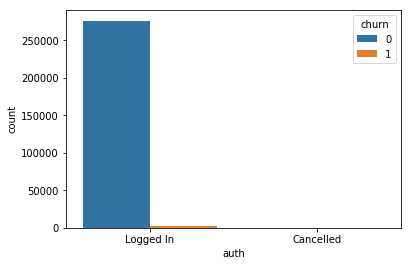

In [42]:
sns.countplot(x="auth", hue="churn", data=auth_df);

Unfortunatelly we have dropped all "guests" in our dataframe. It looks like there is no more info to get from here.

#### 3. "firstName" feature

In [43]:
# get closer look to firstName
log_events.select("firstName").dropDuplicates().sort("firstName", ascending = False).show(5)
log_events.select("firstName").dropDuplicates().sort("firstName").show(5)

+---------+
|firstName|
+---------+
|   Zyonna|
|     Zoey|
|      Zoe|
|  William|
|   Wesley|
+---------+
only showing top 5 rows

+---------+
|firstName|
+---------+
| Adelaida|
|   Adrian|
|  Adriana|
|   Adriel|
|  Ainsley|
+---------+
only showing top 5 rows



For the moment I do not see something strange in this field

#### 4. "gender" feature¶

In [44]:
# check gender feature
log_events.groupBy("gender") \
    .count() \
    .withColumnRenamed('count', 'cnt_per_group') \
    .withColumn('perc_of_count_total', (F.col('cnt_per_group') / log_events.count()) * 100 ) \
    .show()

+------+-------------+-------------------+
|gender|cnt_per_group|perc_of_count_total|
+------+-------------+-------------------+
|     F|       154578| 55.572812183179096|
|     M|       123576|   44.4271878168209|
+------+-------------+-------------------+



In [45]:
gender_df = log_events.select("gender", "churn").toPandas()

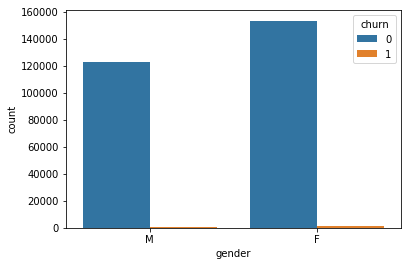

In [46]:
sns.countplot(x="gender", hue="churn", data=gender_df);

It looks like there are slightly more females than males in our dataset

#### 5. "itemInSession" feature

In [47]:
# check itemIn Session feature
log_events.select("userId", "itemInSession").groupBy("userId").count().sort("count").show(5)
log_events.select("userId", "itemInSession").groupBy("userId").count().sort("count", ascending = False).show(5)

+------+-----+
|userId|count|
+------+-----+
|   135|    6|
|   156|    6|
|   125|   11|
|100011|   23|
|300003|   35|
+------+-----+
only showing top 5 rows

+------+-----+
|userId|count|
+------+-----+
|    39| 9632|
|    92| 7230|
|   140| 6880|
|300011| 5732|
|   124| 4825|
+------+-----+
only showing top 5 rows



In [48]:
# get statistics
log_events.describe("itemInSession").show()

+-------+------------------+
|summary|     itemInSession|
+-------+------------------+
|  count|            278154|
|   mean|114.89918174824018|
| stddev|  129.851729399489|
|    min|                 0|
|    max|              1321|
+-------+------------------+



In [49]:
log_events.select("userId","itemInSession", "churn")\
    .groupBy("userId")\
    .agg(F.count('itemInSession'))\
    .orderBy('count(itemInSession)', ascending = False)\
    .show()

+------+--------------------+
|userId|count(itemInSession)|
+------+--------------------+
|    39|                9632|
|    92|                7230|
|   140|                6880|
|300011|                5732|
|   124|                4825|
|300021|                4659|
|300017|                4428|
|    85|                4370|
|    42|                4257|
|200023|                3769|
|     6|                3761|
|    29|                3603|
|    54|                3437|
|   100|                3214|
|     9|                3191|
|   126|                3102|
|300015|                3051|
|    91|                3014|
|    98|                2891|
|    74|                2887|
+------+--------------------+
only showing top 20 rows



In [50]:
inSession_df = log_events.select("userId","itemInSession", "churn")\
    .groupBy("userId")\
    .agg({'itemInSession': 'count', 'churn': 'sum'})\
    .orderBy('sum(churn)', ascending = False).toPandas()

In [51]:
inSession_df.head()

,userId,count(itemInSession),sum(churn)
0,39,9632,73
1,92,7230,68
2,140,6880,50
3,200023,3769,44
4,85,4370,42


In [52]:
inSession_df.tail()

,userId,count(itemInSession),sum(churn)
220,151,163,0
221,76,272,0
222,80,474,0
223,57,112,0
224,119,223,0


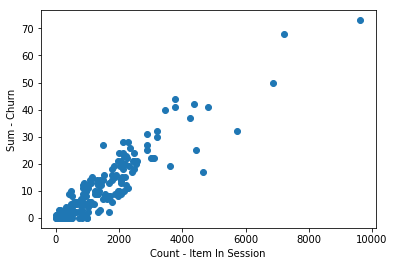

In [53]:
plt.scatter(inSession_df["count(itemInSession)"], inSession_df["sum(churn)"])
plt.xlabel("Count - Item In Session")
plt.ylabel("Sum - Churn");

In [54]:
log_events.select("userId","itemInSession", "churn")\
    .groupBy("userId")\
    .agg({'itemInSession': 'count', 'churn': 'sum'})\
    .orderBy('sum(churn)', ascending = False).describe().show()

+-------+------------------+--------------------+------------------+
|summary|            userId|count(itemInSession)|        sum(churn)|
+-------+------------------+--------------------+------------------+
|  count|               225|                 225|               225|
|   mean|65391.013333333336|             1236.24| 9.364444444444445|
| stddev|105396.47791907164|  1329.5317164325193|11.689455633855365|
|    min|                10|                   6|                 0|
|    max|                99|                9632|                73|
+-------+------------------+--------------------+------------------+



#### 6. "lastName" feature

In [55]:
# check possible typos in lastname
log_events.select("lastName").dropDuplicates().sort("lastName", ascending = False).show(5)
log_events.select("lastName").dropDuplicates().sort("lastName").show(5)

+---------+
| lastName|
+---------+
|   Wright|
|     Wood|
|     Wolf|
| Williams|
|Whitehead|
+---------+
only showing top 5 rows

+---------+
| lastName|
+---------+
|    Adams|
|  Aguilar|
|Alexander|
|    Allen|
| Atkinson|
+---------+
only showing top 5 rows



All gut here

#### 7. "length" feature

In [56]:
# get statistics
log_events.describe("length").show()

+-------+------------------+
|summary|            length|
+-------+------------------+
|  count|            278154|
|   mean|204.29554184589276|
| stddev|131.27340104312333|
|    min|               0.0|
|    max|        3024.66567|
+-------+------------------+



In [57]:
# save to pandas dataframe to get some visualizations
length_df = log_events.select("userId", "length").toPandas()

In [58]:
print(length_df.groupby("userId").mean().sort_values(by = "length").head())
print(length_df.groupby("userId").mean().sort_values(by = "length").tail())

            length
userId            
156     115.278140
100011  123.552152
100006  133.065706
100024  143.348113
68      147.493604
            length
userId            
63      216.372364
100014  218.398297
300024  222.535727
100002  227.339074
135     266.074102


In [59]:
# check where we have maximum values
length_df.loc[length_df.length == length_df.length.max()]

,userId,length
706,126,3024.66567
24252,39,3024.66567
25408,101,3024.66567
92343,85,3024.66567
117632,88,3024.66567
254586,300009,3024.66567
261864,300018,3024.66567
277019,300023,3024.66567


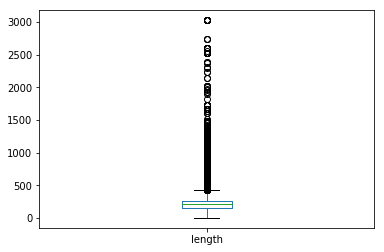

In [60]:
# check boxplot for outliers
length_df.length.plot(kind = "box");

In [61]:
# check quantiles
length_df.length.quantile([.25, .5, .75, .90, .95, .99])

0.25    157.41342
0.50    220.13342
0.75    265.58649
0.90    327.96689
0.95    385.59302
0.99    560.22159
Name: length, dtype: float64

In [62]:
# check in the very last quantile how many values we have
len(length_df.loc[length_df.length > length_df.length.quantile( .999)])

278

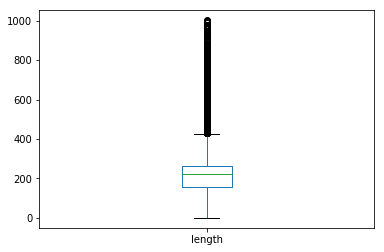

In [63]:
# plot valid values
length_df.loc[length_df.length < length_df.length.quantile( .999)].plot(kind = "box");

In [64]:
# check outliers threshold
length_df.loc[length_df.length == length_df.length.quantile( .999)]

,userId,length
142138,60,1001.74322
201665,111,1001.74322
269081,300021,1001.74322


In [65]:
# check reccords to drop
log_events.filter(log_events["length"] > 1000).count()

282

In [66]:
# keep records with session length beloow 1000 minutes
log_events = log_events.filter(log_events["length"] < 1000)

#### 8. "level" feature

In [67]:
log_events.groupBy("level").count().show()

+-----+------+
|level| count|
+-----+------+
| free| 55666|
| paid|222206|
+-----+------+



In [68]:
log_events.groupBy("level") \
    .count() \
    .withColumnRenamed('count', 'cnt_per_group') \
    .withColumn('perc_of_count_total', (F.col('cnt_per_group') / log_events.count()) * 100 ) \
    .show()

+-----+-------------+-------------------+
|level|cnt_per_group|perc_of_count_total|
+-----+-------------+-------------------+
| free|        55666|  20.03296481833362|
| paid|       222206|  79.96703518166638|
+-----+-------------+-------------------+



20 % are free consumers and 80 % paid. It doest't seem very realistic but it is fictional data!

#### 9. "location" feature

In [69]:
loc_df = log_events.groupBy("location").count().orderBy("count", ascending = False).toPandas()

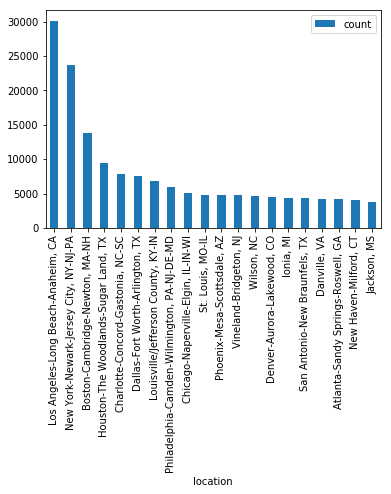

In [70]:
loc_df.set_index('location').head(20).plot(kind = 'bar');

#### 10. "method" feature

In [71]:
# get unique values for "method" feature
[row['method'] for row in log_events.select('method').dropDuplicates().collect()]

['PUT', 'GET']

It looks like "method" feature can be either get or put

#### 11. "page" feature

In [72]:
# get unique values for "page" feature
[row['page'] for row in log_events.select('page').dropDuplicates().collect()]

['Cancel',
 'Submit Downgrade',
 'Thumbs Down',
 'Home',
 'Downgrade',
 'Roll Advert',
 'Logout',
 'Save Settings',
 'Cancellation Confirmation',
 'About',
 'Settings',
 'Add to Playlist',
 'Add Friend',
 'NextSong',
 'Thumbs Up',
 'Help',
 'Upgrade',
 'Error',
 'Submit Upgrade']

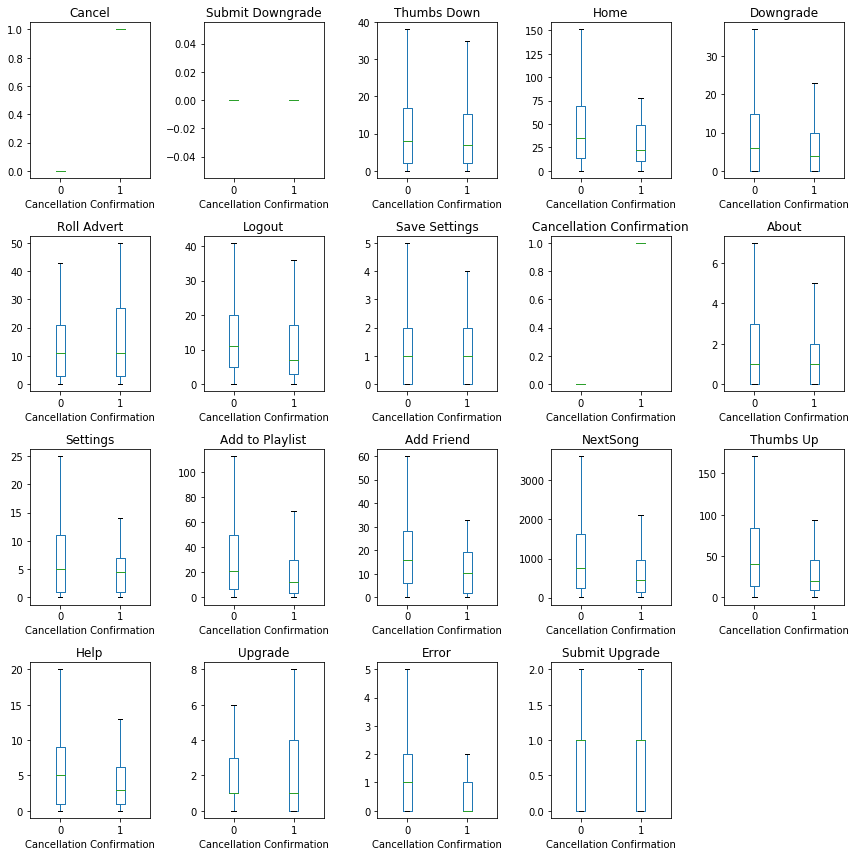

In [73]:
# count page events 
page_df = log_events.groupBy(['userId']).pivot('page').count().fillna(0).toPandas()

# Visualize churn patterns by page event
fig = plt.figure(figsize=(12, 12))
page_cols = [row['page'] for row in log_events.select('page').dropDuplicates().collect()]

for i, col in enumerate(page_cols):
    ax = fig.add_subplot(4,5,i+1)
    page_df.boxplot(col, ax=ax, grid=False,  by='Cancellation Confirmation', showfliers=False);

fig.suptitle('')
plt.tight_layout()

Here we have all page features we can exlore

#### 12. "registration" feature

In [74]:
# get unique values for "page" feature
len([row['registration'] for row in log_events.select('registration').dropDuplicates().collect()])

225

In [75]:
[row['registration'] for row in log_events.select('registration').dropDuplicates().collect()][0]

1529027541000

It looks like a 13 digit length id linked with some sort of id

#### 13. "sessionId" feature

In [76]:
[row['sessionId'] for row in log_events.select('sessionId').dropDuplicates().collect()]

[29,
 26,
 474,
 964,
 1697,
 1806,
 2040,
 1950,
 2214,
 418,
 65,
 541,
 558,
 1010,
 1224,
 1277,
 1258,
 1360,
 1840,
 2173,
 191,
 222,
 293,
 270,
 730,
 938,
 1127,
 1371,
 1409,
 1551,
 1642,
 1145,
 2184,
 278,
 442,
 367,
 705,
 720,
 1202,
 1175,
 243,
 1532,
 1690,
 1919,
 1936,
 2030,
 296,
 54,
 926,
 1280,
 1217,
 1447,
 1537,
 1671,
 1782,
 965,
 19,
 277,
 287,
 348,
 415,
 847,
 1077,
 1336,
 1594,
 1958,
 502,
 1055,
 1480,
 656,
 1921,
 2088,
 2244,
 112,
 299,
 113,
 385,
 167,
 831,
 736,
 1042,
 1738,
 1882,
 1599,
 2175,
 2403,
 155,
 241,
 237,
 347,
 602,
 564,
 588,
 857,
 1547,
 1636,
 1740,
 1497,
 1983,
 198,
 330,
 530,
 414,
 724,
 1241,
 1211,
 1640,
 1526,
 1905,
 1338,
 1711,
 2355,
 22,
 486,
 427,
 487,
 823,
 1050,
 932,
 1152,
 1157,
 1059,
 1403,
 1374,
 1428,
 1972,
 2282,
 130,
 196,
 677,
 1353,
 1505,
 1760,
 2007,
 1979,
 2241,
 1873,
 77,
 7,
 532,
 635,
 858,
 1041,
 1427,
 1529,
 1687,
 1540,
 1887,
 34,
 184,
 463,
 551,
 830,
 939,
 853

These are sessions people have completed

#### 14. "song" feature

In [77]:
len([row['song'] for row in log_events.select('song').dropDuplicates().collect()])

58380

There are 58300 unique features

Perform some NLP to see if we can see a clear pattern 

In [78]:
# split the song text into separate words
regexTokenizer = RegexTokenizer(inputCol = "song", outputCol="words", pattern="\\W")
log_events = regexTokenizer.transform(log_events)
log_events.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', churn=0, words=['rockpools'])

In [79]:
# find the term frequencies of the words
cv = CountVectorizer(inputCol="words", outputCol="TF", vocabSize=1000)
cvmodel = cv.fit(log_events)
log_events = cvmodel.transform(log_events)
df.take(1)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30')]

In [80]:
# show the vocabulary in order of 
cvmodel.vocabulary[0:5]

['no_song', 'the', 'version', 'album', 'you']

In [81]:
# show the last 10 terms in the vocabulary
cvmodel.vocabulary[-10:]

['avenue',
 'heights',
 'higher',
 'lightning',
 'confusion',
 'ball',
 'lay',
 'floor',
 'sometimes',
 'victoria']

I would leave space to a specific NLP specific analisis to a latter moment.

#### 15. "status" feature

In [82]:
[row['status'] for row in log_events.select('status').dropDuplicates().collect()]

[307, 404, 200]

#### 16. "ts" feature - Count songs within a time fraction

To do so we first need to convert the timestamps to datetime from epoch time. In this way we can run specific analytics based on hour, day, weekend, month etc.

Check how many songs a user has listened to in a particular hour, day, month.
We have to convert timestamp to datetime from epoch time to get the hour of the day.

In [83]:
# max timestamp
datetime.datetime.fromtimestamp(log_events.agg({"ts": "max"}).collect()[0][0] / 1000.0)

datetime.datetime(2018, 12, 3, 1, 11, 16)

In [84]:
# min timestamp
datetime.datetime.fromtimestamp(log_events.agg({"ts": "min"}).collect()[0][0] / 1000.0)

datetime.datetime(2018, 10, 1, 0, 1, 57)

The experiment lasted from **1 October 2018** to **3 Dicember 2018** 

In [85]:
# define a user- defined function called "get_hour"
get_hour = F.udf(lambda dt_value: datetime.datetime.fromtimestamp(dt_value / 1000.0).hour)
get_day = F.udf(lambda dt_value: datetime.datetime.fromtimestamp(dt_value / 1000.0).day)
get_weekday = F.udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).weekday(), IntegerType())
get_month = F.udf(lambda dt_value: datetime.datetime.fromtimestamp(dt_value / 1000.0).month)

#use get_hour to create a new column called "hour" in our dataframe
log_events = log_events.withColumn("hour", get_hour(log_events.ts))
log_events = log_events.withColumn("day", get_day(log_events.ts))
log_events = log_events.withColumn("weekday", get_weekday(log_events.ts))
log_events = log_events.withColumn("month", get_month(log_events.ts))

In [86]:
def nextsong_ts(ts_element):
    log_events.filter(log_events.page == "NextSong")\
    .groupby(log_events[ts_element])\
    .count()\
    .orderBy(log_events[ts_element].cast("float"))\
    .toPandas()\
    .plot(kind = "bar");

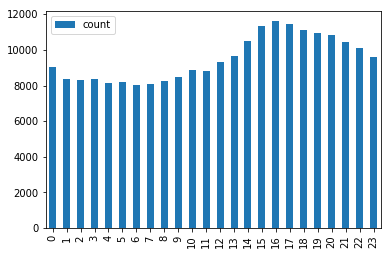

In [87]:
nextsong_ts("hour")

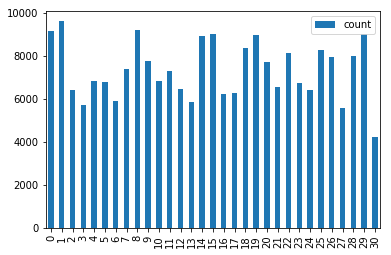

In [88]:
nextsong_ts("day")

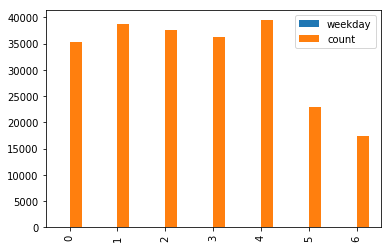

In [89]:
nextsong_ts("weekday")

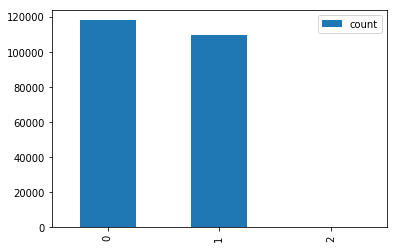

In [90]:
nextsong_ts("month")

We do not have year data available to perform seasonal churn rate. From personal experience I would like to check higher rates of churn in September - after the end of a specific offer for the summer.

In [91]:
churn_week = log_events.select(['userId', 'weekday', 'churn'])\
    .dropDuplicates()\
    .groupBy('weekday')\
    .agg(F.count('userId').alias('num_users'), F.sum('churn').alias('num_churns')).toPandas()

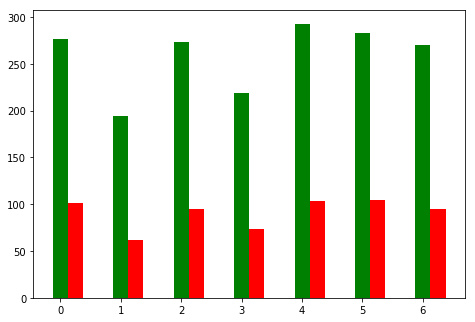

In [92]:
x_axis = np.arange(7)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(x_axis + 0.00, churn_week.num_users, color = 'g', width = 0.25)
ax.bar(x_axis + 0.25, churn_week.num_churns, color = 'r', width = 0.25);

We see the same pattern in normal and churn users.

#### 17. "userAgent" feature

In [93]:
agent_list = [row['userAgent'] for row in log_events.select('userAgent').dropDuplicates().collect()]

In [94]:
log_events.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- churn: integer (nullable = true)
 |-- words: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- TF: vector (nullable = true)
 |-- hour: string (nullable = true)
 |-- day: string (nullable = true)
 |-- weekday: integer (nullable = true)
 |-- month: string (nullable = true)



In [95]:
churn_func = F.udf(lambda churn: 'churn' if churn == 1 else 'stay')
get_device = F.udf(lambda x: x.split('(')[1].replace(";", " ").split(" ")[0])

log_events = log_events.withColumn("device", get_device(log_events["userAgent"]))

In [96]:
device_df = log_events.select(["userId", 'device', 'churn'])\
    .dropDuplicates()\
    .withColumn('churn', churn_func('churn'))\
    .toPandas()

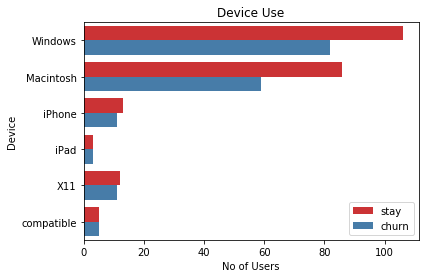

In [97]:
fig = plt.figure()
sns.countplot(y = device_df.device, hue = device_df.churn, data = device_df, palette="Set1");
plt.xticks()
plt.yticks()
plt.xlabel("No of Users")
plt.ylabel("Device")
plt.title("Device Use")
plt.legend(loc='best');

In [14]:
def get_device_col(log_events):
    get_device = F.udf(lambda x: x.split('(')[1].replace(";", " ").split(" ")[0])

    log_events = log_events.withColumn("device", get_device(log_events["userAgent"]))
    return log_events

In [15]:
log_events = get_device_col(log_events)

#### 18. "artist" feature

In [30]:
[row['artist'] for row in log_events.select('artist').dropDuplicates().collect()][0:5]

['The Black Keys',
 'Silverstein',
 'Kate Nash',
 'Yann Tiersen',
 "Jane's Addiction"]

In [31]:
log_events.persist()

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string, churn: int, device: string]

I would suggest NLP separate analysis using artist feature

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

#### Create a `phase` feature using Window Functions

Window functions are a way of combining the values of ranges of rows in a DataFrame. When defining the window we can choose how to sort and group (with the `partitionBy` method) the rows and how wide of a window we'd like to use (described by `rangeBetween` or `rowsBetween`).

In our computation we want to distinguish a user's activity before and after a particular event, for example before and after they have downgraded from a paid to a free one.



In [16]:
def create_phase_col(log_events):

    # for each user order actions by between certain events
    windowval = Window.partitionBy("userId").orderBy(F.desc("ts")).rangeBetween(Window.unboundedPreceding, 0)

    log_events = log_events.withColumn("phase", F.sum("churn").over(windowval))

    return log_events

In [17]:
log_events = create_phase_col(log_events)

#### Create numerical features
1. sum(itemInSession)
2. max(phase)
3. avg(length)

In [116]:
log_events.select("userId","itemInSession", "churn", "phase", "length")\
    .groupBy("userId")\
    .agg(F.count(log_events.userId).alias("count_user_logs"),\
        F.max(log_events.itemInSession).alias("max_session"),\
        F.sum(log_events.churn).alias("sum_churn"),\
        F.max(log_events.phase).alias("max_phase"),\
        F.avg(log_events.length).alias("avg_length"))\
    .orderBy('sum_churn', ascending = False).show()

+------+---------------+-----------+---------+---------+------------------+
|userId|count_user_logs|max_session|sum_churn|max_phase|        avg_length|
+------+---------------+-----------+---------+---------+------------------+
|    39|           9625|        593|       73|       73|205.63061037610322|
|    92|           7217|        551|       68|       68|204.10573571982778|
|   140|           6873|        669|       50|       50|203.53989229012066|
|200023|           3762|        277|       44|       44|192.96495404306242|
|    85|           4364|        647|       42|       42|206.21607341888128|
|   124|           4821|        530|       41|       41|208.63698934245997|
|     6|           3759|        567|       41|       41|208.86627088321356|
|    54|           3433|        581|       40|       40| 205.6916617593945|
|    42|           4256|        306|       37|       37|206.85918675516885|
|300011|           5727|        438|       32|       32|199.29714455212144|
|     9|    

sum_churn and max_phase are the same

In [117]:
# check average phase in dataframe
log_events.select("userId","itemInSession", "churn", "phase", "length")\
    .groupBy("userId")\
    .agg({'itemInSession': 'max', \
          'churn': 'sum', \
          "phase": 'avg', \
          "length": 'avg'})\
    .orderBy('sum(churn)', ascending = False).show()

+------+------------------+------------------+----------+------------------+
|userId|        avg(phase)|max(itemInSession)|sum(churn)|       avg(length)|
+------+------------------+------------------+----------+------------------+
|    39| 35.01433766233766|               593|        73|205.63061037610322|
|    92|35.375640847997786|               551|        68|204.10573571982778|
|   140|27.069838498472283|               669|        50|203.53989229012066|
|200023|16.994683678894205|               277|        44|192.96495404306242|
|    85|24.683547204399634|               647|        42|206.21607341888128|
|   124| 19.53308442231902|               530|        41|208.63698934245997|
|     6| 20.03564777866454|               567|        41|208.86627088321356|
|    54|21.618700844742207|               581|        40| 205.6916617593945|
|    42|  20.0578007518797|               306|        37|206.85918675516885|
|300011| 18.33612711716431|               438|        32|199.29714455212144|

In [18]:
# lets keep count_user_logs, max_session and avg_length to avoid overfitting 
# and be cautious with avg_phase which may ha to be removed
def create_num_df(log_events):
    num_df = log_events.select("userId","itemInSession", "phase", "length")\
    .groupBy("userId")\
    .agg(F.count(log_events.userId).alias("count_user_logs"),\
        F.max(log_events.itemInSession).alias("max_session"),\
        F.avg(log_events.phase).alias("avg_phase"),\
        F.avg(log_events.length).alias("avg_length"))
    
    return num_df

In [19]:
num_df = create_num_df(log_events)

#### Treating categorial features (to dummy)
1. User Device
2. User Location
3. User Page
4. User Status

In [120]:
# isolating device feature
log_events.select('userId','device')\
        .groupBy('userId', 'device')\
        .agg(F.count(log_events.device))\
        .orderBy("count(device)", ascending = False)\
        .show(3)

+------+-------+-------------+
|userId| device|count(device)|
+------+-------+-------------+
|    39|Windows|         9625|
|    92|   iPad|         7217|
|   140|Windows|         6873|
+------+-------+-------------+
only showing top 3 rows



In [121]:
# isolating location feature
log_events.select('userId','location')\
        .groupBy('userId', 'location')\
        .agg(F.count('location'))\
        .orderBy("count(location)", ascending = False)\
        .show(3)

+------+--------------------+---------------+
|userId|            location|count(location)|
+------+--------------------+---------------+
|    39|Los Angeles-Long ...|           9625|
|    92|Boston-Cambridge-...|           7217|
|   140|Louisville/Jeffer...|           6873|
+------+--------------------+---------------+
only showing top 3 rows



In [138]:
# isolating page feature
log_events.select('userId','page')\
        .groupBy('userId', 'page')\
        .agg(F.count('page'))\
        .orderBy("count(page)", ascending = False)\
        .show(3)

+------+--------+-----------+
|userId|    page|count(page)|
+------+--------+-----------+
|    39|NextSong|       7995|
|    92|NextSong|       5932|
|   140|NextSong|       5657|
+------+--------+-----------+
only showing top 3 rows



In [139]:
# isolating status feature
log_events.select('userId','status')\
        .groupBy('userId', 'status')\
        .agg(F.count('status'))\
        .orderBy("count(status)", ascending = False)\
        .show(3)

+------+------+-------------+
|userId|status|count(status)|
+------+------+-------------+
|    39|   200|         8902|
|    92|   200|         6650|
|   140|   200|         6270|
+------+------+-------------+
only showing top 3 rows



Checking we have one device per uderId

In [141]:
# cheking the number of unique userIds and the number of unique devices per userID
len(log_events.dropDuplicates()\
    .groupBy('userId')\
    .count()\
    .collect())\
    ==\
len(log_events.dropDuplicates()\
    .select('userId','device')\
    .groupBy('userId', 'device')\
    .agg(F.count("device"))\
    .collect())

True

In [142]:
# cheking the number of unique userIds and the number of unique gender per userID
len(log_events.dropDuplicates()\
    .groupBy('userId')\
    .count()\
    .collect())\
    ==\
len(log_events.dropDuplicates()\
    .select('userId','gender')\
    .groupBy('userId', 'gender')\
    .agg(F.count("gender"))\
    .collect())

True

In [143]:
# cheking the number of unique userIds and the number of unique level per userID
len(log_events.dropDuplicates()\
    .groupBy('userId')\
    .count()\
    .collect())\
    ==\
len(log_events.dropDuplicates()\
    .select('userId','level')\
    .groupBy('userId', 'level')\
    .agg(F.count("level"))\
    .collect())

False

In [146]:
# cheking the number of unique userIds and the number of unique auth per userID
len(log_events.dropDuplicates()\
    .groupBy('userId')\
    .count()\
    .collect())\
    ==\
len(log_events.dropDuplicates()\
    .select('userId','method')\
    .groupBy('userId', 'method')\
    .agg(count("method"))\
    .collect())

False

In [144]:
# cheking the number of unique userIds and the number of unique auth per userID
len(log_events.dropDuplicates()\
    .groupBy('userId')\
    .count()\
    .collect())\
    ==\
len(log_events.dropDuplicates()\
    .select('userId','auth')\
    .groupBy('userId', 'auth')\
    .agg(F.count("auth"))\
    .collect())

False

In [146]:
# cheking the number of unique userIds and the number of unique location per userID
len(log_events.dropDuplicates()\
    .groupBy('userId')\
    .count()\
    .collect())\
    ==\
len(log_events.dropDuplicates()\
    .select('userId','location')\
    .groupBy('userId', 'location')\
    .agg(F.count("location"))\
    .collect())

True

In [148]:
# cheking the number of unique userIds and the number of unique page per userID
print(len(log_events.dropDuplicates()\
    .select('userId','page')\
    .groupBy('userId', 'page')\
    .agg(F.count("page"))\
    .collect()))
print(len(log_events.dropDuplicates()\
    .groupBy('userId')\
    .count()\
    .collect())\
    ==\
    len(log_events.dropDuplicates()\
    .select('userId','page')\
    .groupBy('userId', 'page')\
    .agg(F.count("page"))\
    .collect()))

3109
False


In [150]:
# cheking the number of unique userIds and the number of unique staus per userID
print(len(log_events.dropDuplicates()\
    .select('userId','status')\
    .groupBy('userId', 'status')\
    .agg(F.count("status"))\
    .collect()))
print(len(log_events.dropDuplicates()\
    .groupBy('userId')\
    .count()\
    .collect())\
    ==\
    len(log_events.dropDuplicates()\
    .select('userId','status')\
    .groupBy('userId', 'status')\
    .agg(F.count("status"))\
    .collect()))

565
False


#### Creating dummy features

In [20]:
# create a function to create expressions for creating dummies
def get_dummy_expression(column):
    unique_values = log_events.select(column).distinct().rdd.flatMap(lambda element:element).collect()
    expression = [F.when(F.col(column) == str(el), 1).otherwise(0).alias(column + "_" + str(el)) for el in unique_values]
    
    return expression

In [21]:
def create_cat_df(log_events):
    device_expression = get_dummy_expression("device")
    location_expression = get_dummy_expression("location")
    page_expression = get_dummy_expression("page")
    status_expression = get_dummy_expression("status")
    auth_expression = get_dummy_expression("auth")
    gender_expression = get_dummy_expression("gender")
    level_expression = get_dummy_expression("level")
    method_expression = get_dummy_expression("method")
    cat_df = log_events.select("userId", *device_expression +\
                           location_expression +\
                           page_expression +\
                           status_expression +\
                           auth_expression +\
                           gender_expression +\
                           level_expression +\
                           method_expression)
    return cat_df

In [123]:
device_expression = get_dummy_expression("device")
location_expression = get_dummy_expression("location")
page_expression = get_dummy_expression("page")
status_expression = get_dummy_expression("status")
auth_expression = get_dummy_expression("auth")
gender_expression = get_dummy_expression("gender")
level_expression = get_dummy_expression("level")
method_expression = get_dummy_expression("method")

In [262]:
cat_df = log_events.select("userId", *device_expression +\
                           location_expression +\
                           page_expression +\
                           status_expression +\
                           auth_expression +\
                           gender_expression +\
                           level_expression +\
                           method_expression)

In [22]:
cat_df = create_cat_df(log_events)

In [39]:
cat_df.count()

278154

`device` and `location` features are binary for every user while there are more than one `pages` or `status` values per user so we have to count them and treat these features as numeric and not categorical.

In [40]:
cat_df.columns

['userId',
 'device_iPad',
 'device_X11',
 'device_iPhone',
 'device_Macintosh',
 'device_compatible',
 'device_Windows',
 'location_Gainesville, FL',
 'location_Atlantic City-Hammonton, NJ',
 'location_Deltona-Daytona Beach-Ormond Beach, FL',
 'location_San Diego-Carlsbad, CA',
 'location_Cleveland-Elyria, OH',
 'location_Kingsport-Bristol-Bristol, TN-VA',
 'location_New Haven-Milford, CT',
 'location_Birmingham-Hoover, AL',
 'location_Corpus Christi, TX',
 'location_Dubuque, IA',
 'location_Las Vegas-Henderson-Paradise, NV',
 'location_Indianapolis-Carmel-Anderson, IN',
 'location_Seattle-Tacoma-Bellevue, WA',
 'location_Albany, OR',
 'location_Winston-Salem, NC',
 'location_Bakersfield, CA',
 'location_Los Angeles-Long Beach-Anaheim, CA',
 'location_Minneapolis-St. Paul-Bloomington, MN-WI',
 'location_San Francisco-Oakland-Hayward, CA',
 'location_Phoenix-Mesa-Scottsdale, AZ',
 'location_Allentown-Bethlehem-Easton, PA-NJ',
 'location_Miami-Fort Lauderdale-West Palm Beach, FL',
 'loc

In [23]:
def rename_cols(cat_df):
    
    cat_df = cat_df\
    .withColumnRenamed('location_Minneapolis-St. Paul-Bloomington, MN-WI','location_Minneapolis-St Paul-Bloomington, MN-WI')\
    .withColumnRenamed('location_St. Louis, MO-IL','location_St Louis, MO-IL')\
    .withColumnRenamed('location_Port St. Lucie, FL','location_Port St Lucie, FL')\
    .withColumnRenamed('location_Tampa-St. Petersburg-Clearwater, FL','location_Tampa-St Petersburg-Clearwater, FL')\
    .withColumnRenamed('page_Cancellation Confirmation', 'page_Cancellation_Confirmation')
    
    return cat_df

In [24]:
cat_df = rename_cols(cat_df)

In [70]:
def binarize_id(df, df_list):
    df = df.select(df_list).groupBy('userID').avg()
    get_bins = F.udf(lambda x: 0 if x == 0 else 1)
    for col in df.columns:
        if col != "userID":
            df = df.withColumn(col, get_bins(df[col]))
    return df

In [71]:
def separate_cat_dfs(cat_df):
    devices = [col for col in cat_df.columns if 'device' in col] + ['userId']
    locations = [col for col in cat_df.columns if 'location' in col] + ['userId']
    pages = [col for col in cat_df.columns if 'page' in col] + ['userId']
    pages = [col for col in pages if col not in ['page_Cancellation_Confirmation', 'page_Downgrade']]
    status = [col for col in cat_df.columns if 'status' in col] + ['userId']
    auth = [col for col in cat_df.columns if 'auth' in col] + ['userId']
    gender = [col for col in cat_df.columns if 'gender' in col] + ['userId']
    level = [col for col in cat_df.columns if 'level' in col] + ['userId']
    method = [col for col in cat_df.columns if 'method' in col] + ['userId']

    device_df = binarize_id(cat_df, devices)
    for col in device_df.columns:
        if col != "userID":
            device_df = device_df.withColumnRenamed(col,col[4:-1])
    locations_df = binarize_id(cat_df, locations)
    for col in locations_df.columns:
        if col != "userID":
            locations_df = locations_df.withColumnRenamed(col,col[4:-1])
    pages_df = binarize_id(cat_df, pages)
    for col in pages_df.columns:
        if col != "userID":
            pages_df = pages_df.withColumnRenamed(col,col[4:-1])
    status_df = binarize_id(cat_df, status)
    for col in status_df.columns:
        if col != "userID":
            status_df = status_df.withColumnRenamed(col,col[4:-1])
    auth_df = binarize_id(cat_df, auth)
    for col in auth_df.columns:
        if col != "userID":
            auth_df = auth_df.withColumnRenamed(col,col[4:-1])
    gender_df = binarize_id(cat_df, gender)
    for col in gender_df.columns:
        if col != "userID":
            gender_df = gender_df.withColumnRenamed(col,col[4:-1])
    level_df = binarize_id(cat_df, level)
    for col in level_df.columns:
        if col != "userID":
            level_df = level_df.withColumnRenamed(col,col[4:-1])
    method_df = binarize_id(cat_df, method)
    for col in method_df.columns:
        if col != "userID":
            method_df = method_df.withColumnRenamed(col,col[4:-1])
    
    return device_df, locations_df, pages_df, status_df, auth_df, gender_df, level_df, method_df

In [72]:
device_df, locations_df, pages_df, status_df, auth_df, gender_df, level_df, method_df = separate_cat_dfs(cat_df)

`gender` feature is binary for every user while there are more than one `auth`,`level` and `method` values per user so we have to count them and treat these features as numeric and not categorical.

In [81]:
X = num_df.join(device_df, ["userID"])\
    .join(locations_df, ["userID"])\
    .join(pages_df, ["userID"])\
    .join(status_df, ["userID"])\
    .join(auth_df, ["userID"])\
    .join(gender_df, ["userID"])\
    .join(level_df, ["userID"])\
    .join(method_df, ["userID"])\
    

In [82]:
X.printSchema()

root
 |-- userId: string (nullable = true)
 |-- count_user_logs: long (nullable = false)
 |-- max_session: long (nullable = true)
 |-- avg_phase: double (nullable = true)
 |-- avg_length: double (nullable = true)
 |-- device_iPad: string (nullable = true)
 |-- device_X11: string (nullable = true)
 |-- device_iPhone: string (nullable = true)
 |-- device_Macintosh: string (nullable = true)
 |-- device_compatible: string (nullable = true)
 |-- device_Windows: string (nullable = true)
 |-- location_Gainesville, FL: string (nullable = true)
 |-- location_Atlantic City-Hammonton, NJ: string (nullable = true)
 |-- location_Deltona-Daytona Beach-Ormond Beach, FL: string (nullable = true)
 |-- location_San Diego-Carlsbad, CA: string (nullable = true)
 |-- location_Cleveland-Elyria, OH: string (nullable = true)
 |-- location_Kingsport-Bristol-Bristol, TN-VA: string (nullable = true)
 |-- location_New Haven-Milford, CT: string (nullable = true)
 |-- location_Birmingham-Hoover, AL: string (nullabl

In [83]:
pca = PCA(k=3, inputCol= X , outputCol="pcaFeatures")
model = pca.fit(df)
result = model.transform(df).select("pcaFeatures")
result.show(truncate=False)

NameError: name 'preprocessing' is not defined

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.